## Segment Anything Model (SAM) initialiseren
In dit blok importeren we de benodigde bibliotheken en initialiseren we het SAM-model dat verantwoordelijk is voor de segmentatie.

We kiezen voor het vit_h model (Vision Transformer - Huge), de krachtigste versie van SAM.

We laden de bijbehorende modelgewichten via het bestand sam_vit_h_4b8939.pth.

Tot slot maken we een SamPredictor object aan, waarmee we later segmentatie kunnen uitvoeren op afbeeldingen.

In [1]:
# === Imports en SAM initialiseren ===
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image

sam_checkpoint = "models/sam_vit_h_4b8939.pth" # het .pth bestand met de gewichten van het SAM-model
model_type = "vit_h" # het type ViT (Vision Transformer) architectuur dat SAM gebruikt
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

##  Afbeelding voorbereiden en klikpunten genereren
In dit blok wordt de afbeelding geladen, omgezet naar het juiste kleurformaat (RGB), ingesteld voor gebruik in SAM, en worden meerdere klikpunten gegenereerd rond het midden van de afbeelding. Deze punten vertellen SAM wáár het moet kijken voor segmentatie

In [2]:
# === Afbeelding laden en converteren ===
afbeelding = "vrijstaande_woning (5)_contours.png"
image = cv2.imread(f"Resultaten_met_Contouren/{afbeelding}")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Zet de afbeelding om van BGR naar RGB omdat dat handiger is voor SAM (OpenCV laadt standaard in het BGR-kleurformaat wat is niet compatibel met SAM)
predictor.set_image(image_rgb)

# === Meerdere punten genereren rond het midden ===
h, w, _ = image.shape # image is nu een numpy-array van vorm (hoogte, breedte, 3 (met pixelwaarden tussen 0–255 [120, 0, 255]))
center_x, center_y = w // 2, h // 2
offset_x = 60 #  hoeveel pixels rond het midden we extra punten willen plaatsen
offset_y = 120 #  hoeveel pixels rond het midden we extra punten willen plaatsen

punten = np.array([[center_x + dx, center_y + dy] for dx in [-offset_x, 0, offset_x] for dy in [-offset_y, 0, offset_y]])
labels = np.ones(len(punten))

## Segmentatie uitvoeren en beste masker selecteren
In deze block geven wij de eerder gedefinieerde punten aan het SAM-model (predictor) door om een segmentatie uit te voeren. Het model retourneert meerdere maskers. Elk masker is een mogelijke interpretatie van wat een object kan zijn op basis van de inputpunten. Wij kiesen vervolgens het beste masker op basis van de hoogste confidence score (scores).

De score wordt waarschijnlijk bepaald door een paar factoren zoals

**Factor**                                           Betekenis

**Maskerkwaliteit**                              Hoe scherp/duidelijk is de grens van het masker?

**Overeenkomst met inputprompt (klikpunten)**   Ligt het masker goed om de opgegeven punt(en)?

**Afsluiting (compleetheid)**                   Is het een gesloten contour, zonder gaten?

**Consistentie met features uit de encoder**    Komt het masker overeen met interne kenmerken (textures, randen, vormen)?

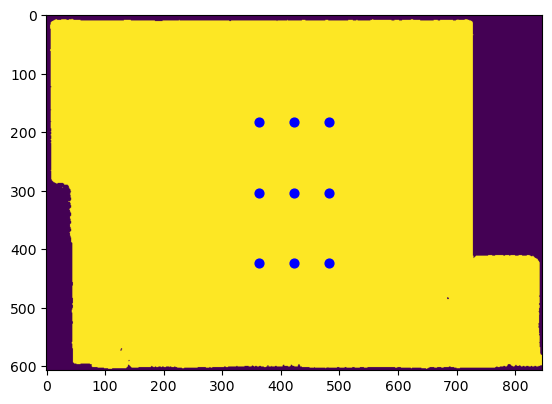

In [3]:
# === Segmentatie uitvoeren ===
masks, scores, _ = predictor.predict(
    point_coords=punten,
    point_labels=labels,
    multimask_output=True
)
beste_mask = masks[np.argmax(scores)] # np.argmax(scores): bepaalt de index van het masker met de hoogste score (dus het meest betrouwbare masker).

plt.imshow(beste_mask)
plt.scatter(punten[:, 0], punten[:, 1], color="blue", s=40, marker="o", label="Invoerpunt")

## Gebouw uitsnijden en opslaan
We willen de originele afbeelding omzetten naar een versie waarin alleen het segment (het huis) zichtbaar is en de rest transparant wordt. Dit is handig voor:

verdere analyse (zoals ramen/deuren zoeken binnen het gebouw),

overlay op de originele afbeelding,

eenvoudiger gebruik van segmentatie in latere stappen.

In [4]:
# === RGBA afbeelding maken met alleen het gebouw ===
huis_rgba = np.zeros((image_rgb.shape[0], image_rgb.shape[1], 4), dtype=np.uint8) # We maken een nieuwe lege afbeelding van dezelfde hoogte & breedte als de originele (image_rgb).
huis_rgba[:, :, :3] = image_rgb # We kopiëren de RGB-waarden van de originele afbeelding.
huis_rgba[:, :, 3] = (beste_mask * 255).astype(np.uint8) # beste_mask is een boolean-array (True/False): waar het huis is gedetecteerd.

# === Opslaan als PNG met transparantie ===
img_pil = Image.fromarray(huis_rgba)
img_pil.save(f"Data_nest_uitgesneden_zonder_achtergrond/{afbeelding}")

## Segmentatie voorbereiden
In dit blok zetten we de afbeelding (image) om naar het RGB-kleurschema, zoals vereist door het SAM-model. Daarna roepen we SamAutomaticMaskGenerator aan om automatisch alle segmenten (objecten) in de afbeelding te detecteren.

In [5]:
# image naar het RGB-kleurschema zetten
huis_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Segmentatie genereren met SAM
mask_generator = SamAutomaticMaskGenerator(sam)
resultaten = mask_generator.generate(huis_image_rgb)

## Grootste segment bepalen
Hier bepalen we de oppervlakte (in pixels) van elk gesegmenteerd object door het aantal True-waarden in de maskers op te tellen. We nemen het grootste aantal als referentie om later segmenten in "klein", "middelgroot" en "groot" te classificeren.

In [6]:
max_area = max(np.sum(m["segmentation"]) for m in resultaten)

## Masker van alleen het gebouw laden
We laden de eerder opgeslagen afbeelding met een transparante achtergrond. Het alpha-kanaal (vierde kanaal) vertelt ons welke pixels tot het gebouw horen (alpha > 0). Deze info wordt gebruikt om alleen segmenten binnen het huis toe te staan.

In [7]:
huis_rgba = np.array(Image.open(f"Data_nest_uitgesneden_zonder_achtergrond/{afbeelding}"))
alpha_mask = huis_rgba[:, :, 3] > 0   # True = gebouw

## Kleur toepassen op gebouwsegmenten
We doorlopen alle segmenten uit de automatische segmentatie. We combineren elk masker met het gebouwmasker om ervoor te zorgen dat we alleen delen binnen het huis inkleuren. Vervolgens bepalen we de kleur op basis van de grootte van het segment en kleuren de corresponderende pixels in de afbeelding

In [8]:
for m in resultaten:
    mask = m["segmentation"]
    area = np.sum(mask)

    # Segmenten buiten het gebouw negeren
    geldig_mask = mask & alpha_mask
    if np.sum(geldig_mask) < area * 0.5: # Als minder dan 50% van het segment binnen het gebouw ligt, wordt het segment overgeslagen.
        continue                         # (Dit voorkomt dat ruis of delen van de achtergrond toch per ongeluk worden ingekleurd.)


    # Kleur op basis van grootte
    if area < max_area * 0.1:
        kleur = [0, 255, 0]      # klein object → groen
    elif area < max_area * 0.5:
        kleur = [255, 255, 0]    # medium object → geel
    else:
        kleur = [255, 0, 0]      # groot object → rood

    for c in range(3):
        huis_image_rgb[:, :, c][geldig_mask] = kleur[c]

## Visualisatie
Tot slot tonen we het resultaat: de originele afbeelding van het huis waarin de gesegmenteerde onderdelen zijn ingekleurd op basis van hun grootte (zonder de achtergrond te kleuren). Hiermee krijgen we visueel inzicht in de structuur van het gebouw.

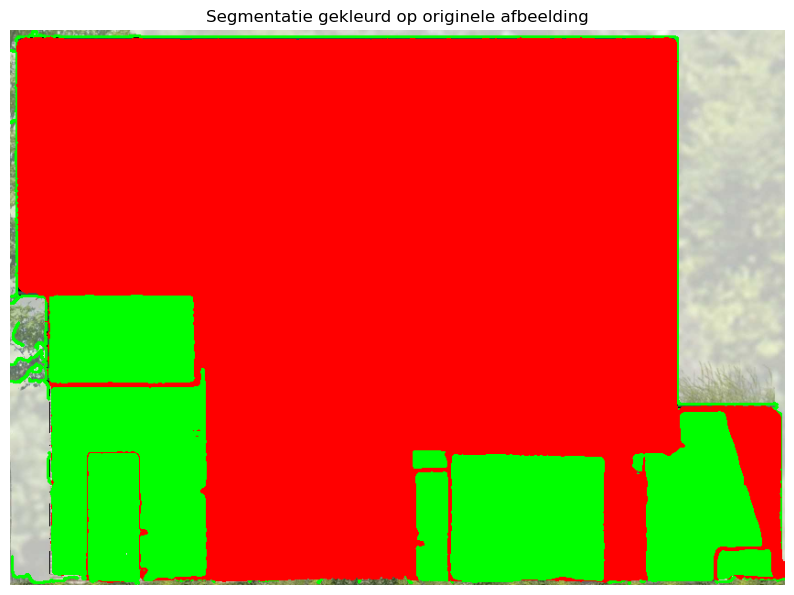

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(huis_image_rgb)
plt.title("Segmentatie gekleurd op originele afbeelding")
plt.axis("off")
plt.show()

In [10]:
Image.fromarray(huis_image_rgb).save(f"Data_nest_uitgesneden_output/{afbeelding}")